In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
from FACS_Sampling.preprocessing.utils import create_adata

sc.set_figure_params(figsize=(8,8), fontsize=15, )

In [2]:
data = pd.read_csv("../../FACS_Sampling/datasets/AML_Aligned_non_normalized_1M.csv")


In [3]:
index = data['Unnamed: 0']
data = data.drop(columns=['Unnamed: 0'])
labels = data['Population']
label_key = 'Population'

In [4]:
adata = create_adata(data, obs_features=label_key)
x = np.arcsinh(adata.X/500)
adata.X = x

/Users/ekarimi/PycharmProjects/FACS_Sampling/FACS_Sampling/preprocessing/utils.py:60: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(X, obs=obs, var=var)
/Users/ekarimi/opt/anaconda3/envs/FACS_Sampling/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
adata

AnnData object with n_obs × n_vars = 1000000 × 22
    obs: 'Population'

In [6]:
from FACS_Sampling.methods.methods import bin_sample, sample_random, dist_sampling

In [7]:
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)
# sc.pl.umap(adata, color=label_key)

In [8]:
# adata.obs

In [9]:
# adata.obs["labels"].cat.categories

In [10]:
from FACS_Sampling.preprocessing.utils import set_reference_colors

# dictionary = set_reference_colors(adata, cluster_key='labels')
# cluster_key = 'labels'
# label_key = 'labels'

# dictionary = set_reference_colors(adata, cluster_key=label_key)
cluster_key = label_key

In [11]:
from FACS_Sampling.plotting.plotting import change_cmap

ref_adata = adata
# change_cmap(ref_adata, dictionary)

### Draw samples

In [13]:
def bin_sample(adata, s_size=20, n_bins=10, seed=12345):
    np.random.seed(seed)
    total_indices = np.array([])
    for gene in adata.var_names.values:
        indices = np.array([])
        mini = adata[:, [gene]]
        std = np.std(np.array(mini.X))
        rng = 12*std
        mean = np.mean(np.array(mini.X))
        
        measures = [-np.inf]
        if n_bins > 2:
            step = rng/(n_bins-2)
        else:
            step = 0
            
        for i in range(n_bins//2 -1):
            measures.append(mean - rng/2 + i*step)
        
        measures.append(mean)
        
        for i in range(n_bins//2 -1):
            measures.append(mean + (i+1)*step)

        measures.append(np.inf)
            
#         measures = [-np.inf]
#         var = (n_bins - 2) / 2
#         for i in range(n_bins - 1):
#             measures.append(mean - var * std)
#             var -= 1
#         measures.append(np.inf)

        for item in range(len(measures) - 1):
            measure1, measure2 = measures[item], measures[item + 1]
            local_indices = adata[np.array(mini.X > measure1) & np.array(mini.X < measure2)].obs.index.to_numpy()
            if len(local_indices) > s_size:
                indices = np.append(indices, np.random.choice(local_indices, s_size, replace=False))
                # if item==0 or item==len(measures)-2:
                #     indices = np.append(indices,local_indices)
                # else:
                #     indices = np.append(indices, np.random.choice(local_indices, s_size, replace=False))
            elif len(local_indices) > 0:
                indices = np.append(indices, local_indices)

        total_indices = np.append(total_indices, indices)

    return np.unique(total_indices), total_indices


In [14]:
from scipy.spatial.distance import pdist, squareform

def dist_sampling(adata, sample_per_matrix=4, rng=1000, seed=12345):
    adata.obs = adata.obs.reset_index()
    np.random.seed(seed)
    all_indices = adata.obs.index.to_numpy().astype(int)
    np.random.shuffle(all_indices)

    start_i = 0
    if all_indices.shape[0] % rng != 0:
        end_of_range = int(all_indices.shape[0] / rng + 1)
    else:
        end_of_range = int(all_indices.shape[0] / rng)

    output = []
    for i in range(end_of_range):
        samples = all_indices[start_i:start_i + rng]
        start_i += rng

        x = adata.X[samples,]
        # x = stats.zscore(x, axis=1)
        dists = squareform(pdist(x, metric='euclidean'))
        th = np.max(dists)
        mask1 = dists > th
        while (mask1.sum(axis=1) > 0).sum() < 2 * sample_per_matrix:
            th = th / 2
            mask1 = dists > th

        mask = mask1

        fin_scores = np.multiply(dists, mask).sum(axis=0)
        t = samples[np.argsort(fin_scores)[0:sample_per_matrix]]
        output.extend(t)

    output = adata.obs.loc[output]['index'].values
    adata.obs.index = adata.obs['index']
    del adata.obs['index']
    return np.array(output)

In [15]:
fsbs_samples, _ = bin_sample(ref_adata, n_bins=30, s_size=78)
print(fsbs_samples.size)
random_samples = sample_random(ref_adata, s_size=fsbs_samples.size)


30390


In [16]:
dist_samples = dist_sampling(ref_adata, sample_per_matrix=30, rng=1000, seed= 1356)

In [17]:
dist_samples.shape

(30000,)

### Plots

In [18]:
sc.set_figure_params(dpi=300, color_map = 'viridis_r', figsize=(8,8), fontsize=15,)
sc.settings.verbosity = 1
sc.logging.print_header()
# sc.set_figure_params(figsize=(8,8), fontsize=15, )



scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.5.2 scikit-learn==1.2.0 statsmodels==0.13.5 python-igraph==0.9.11 pynndescent==0.5.8


In [19]:
adata_random = ref_adata[random_samples]
# change_cmap(adata_random, dictionary, celltype_key=label_key)
# sc.tl.leiden(adata_random, resolution= 2)

In [20]:
# sc.pl.umap(adata_random, color=['leiden', label_key], save= "random_schayan")

In [21]:
adata_fsbs = ref_adata[fsbs_samples]
# change_cmap(adata_fsbs, dictionary, celltype_key=label_key)
# sc.tl.leiden(adata_fsbs, resolution= 2)

In [22]:
# sc.pl.umap(adata_fsbs, color=['leiden', label_key], save='FSBS_schayan')

In [23]:
adata_dist = ref_adata[dist_samples]
# change_cmap(adata_prop, dictionary,celltype_key=label_key)
# sc.tl.leiden(adata_prop, resolution= 2)

In [24]:
# sc.pl.umap(adata_prop, color=['leiden', label_key], save="prop")

In [25]:
cell_type_order = ref_adata.obs[label_key].value_counts().keys().values

### Bootstraping

In [26]:
# from FACS_Sampling.methods.analysis import bootstrap

In [27]:
def bootstrap(ref_adata, label_key='labels', rep=5, seed=12345):
    np.random.seed(seed)

    groupped_df = pd.DataFrame(data=None, columns=["count", label_key, "method"])
    for i in range(rep):
        new_seed = np.random.randint(100000)

        ps, _ = bin_sample(ref_adata, n_bins=14, s_size=20, seed=new_seed)
        rs = sample_random(ref_adata, s_size=ps.size, seed=new_seed)
        dist_s = dist_sampling(ref_adata, sample_per_matrix=30, rng=1000, seed=new_seed)
        
        def automation(samples, method_type='Random'):
            a = ref_adata[samples].obs[label_key].value_counts().to_list()
            b = list(ref_adata[samples].obs[label_key].value_counts().keys())
            c = [method_type for _ in a]
            g_df = pd.DataFrame({"count": a, label_key: b, "method": c})
            return g_df

        g_df1 = automation(rs, method_type='Random')
        g_df2 = automation(ps, method_type='FSBS')
        g_df3 = automation(dist_s, method_type='Dist')

        groupped_df = pd.concat([groupped_df, g_df1, g_df2, g_df3])
    return groupped_df

In [28]:
df_bootstrap = bootstrap(ref_adata, label_key=label_key, rep=5)

In [29]:
df_random = df_bootstrap[df_bootstrap['method'].isin(['Random'])]
df_fsbs = df_bootstrap[df_bootstrap['method'].isin(['FSBS'])]
df_dist = df_bootstrap[df_bootstrap['method'].isin(['Dist'])]

In [30]:
import seaborn as sns

sns.set(font_scale=1.5)

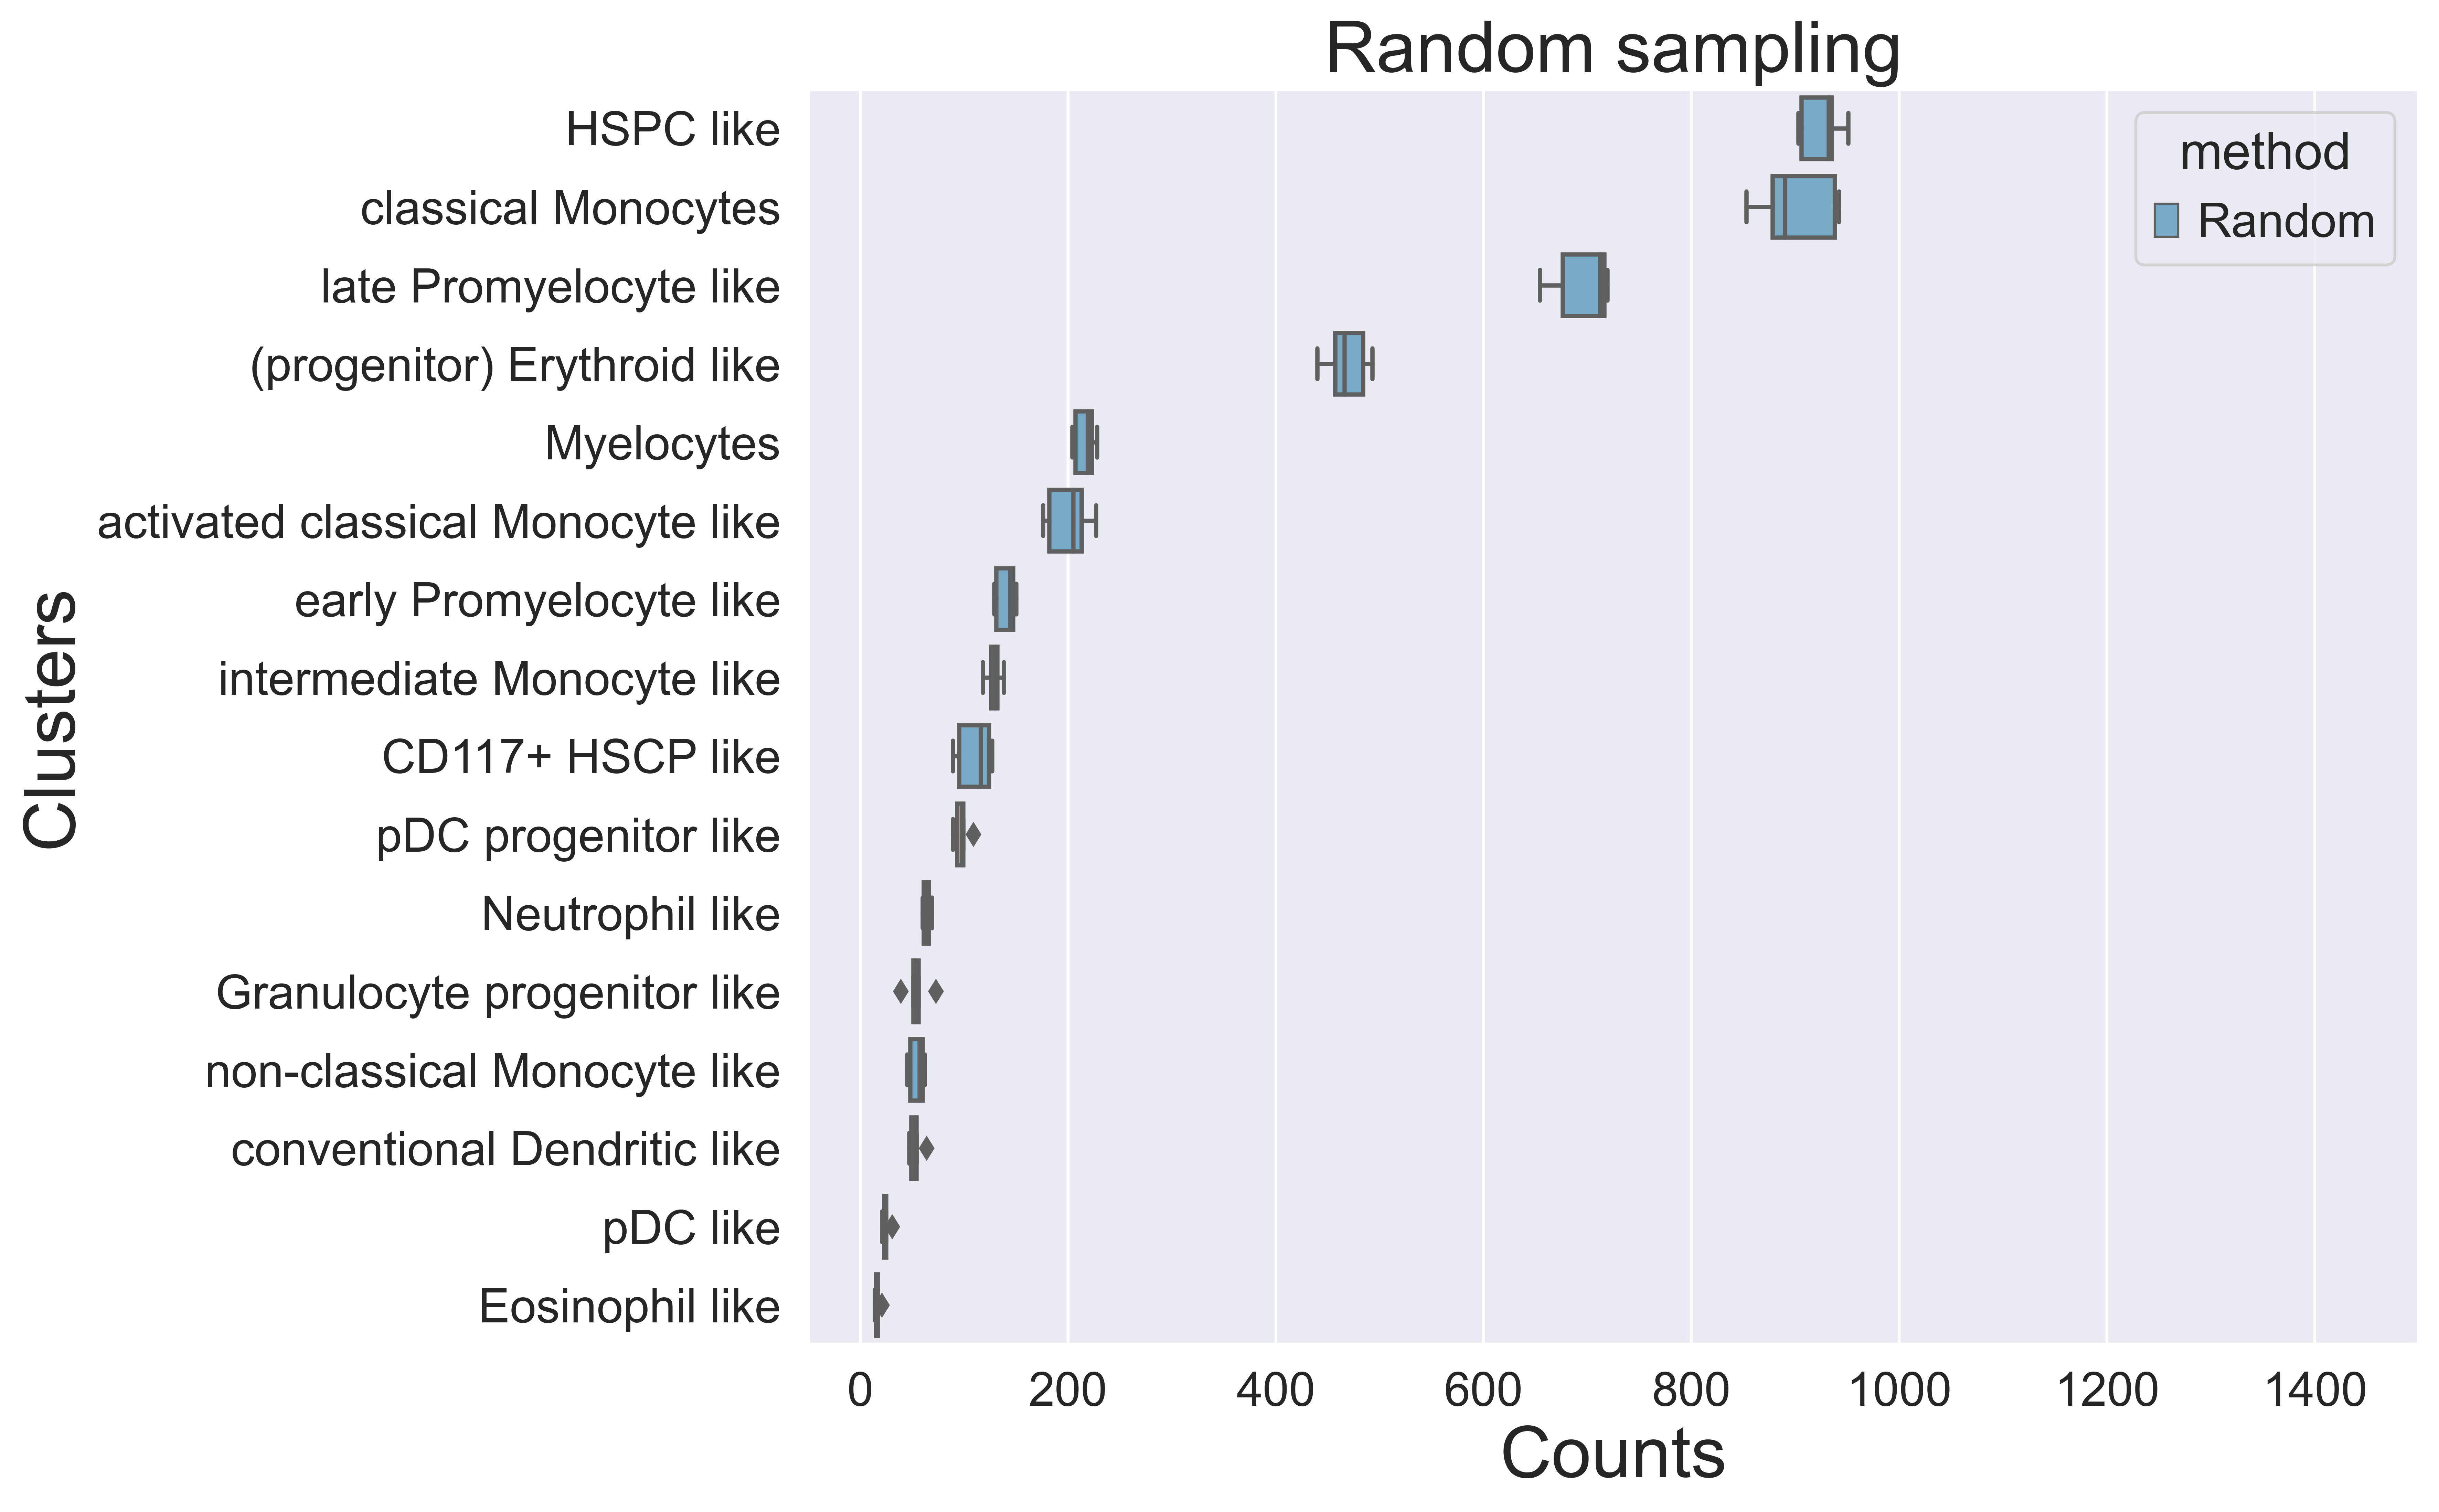

In [31]:
plt.figure(figsize=(10, 8))
g = sns.boxplot(y=label_key, x="count", hue='method',data=df_random,
                orient='h', order= cell_type_order, palette="Blues")
plt.xlim(-50, 1500)
# plt.xticks(rotation=90)
plt.ylabel("Clusters", size = 25)
plt.xlabel("Counts", size = 25)
plt.title("Random sampling", size= 25)
plt.savefig("Random_new.png", dpi=200, bbox_inches='tight', pad_inches = 0.5)

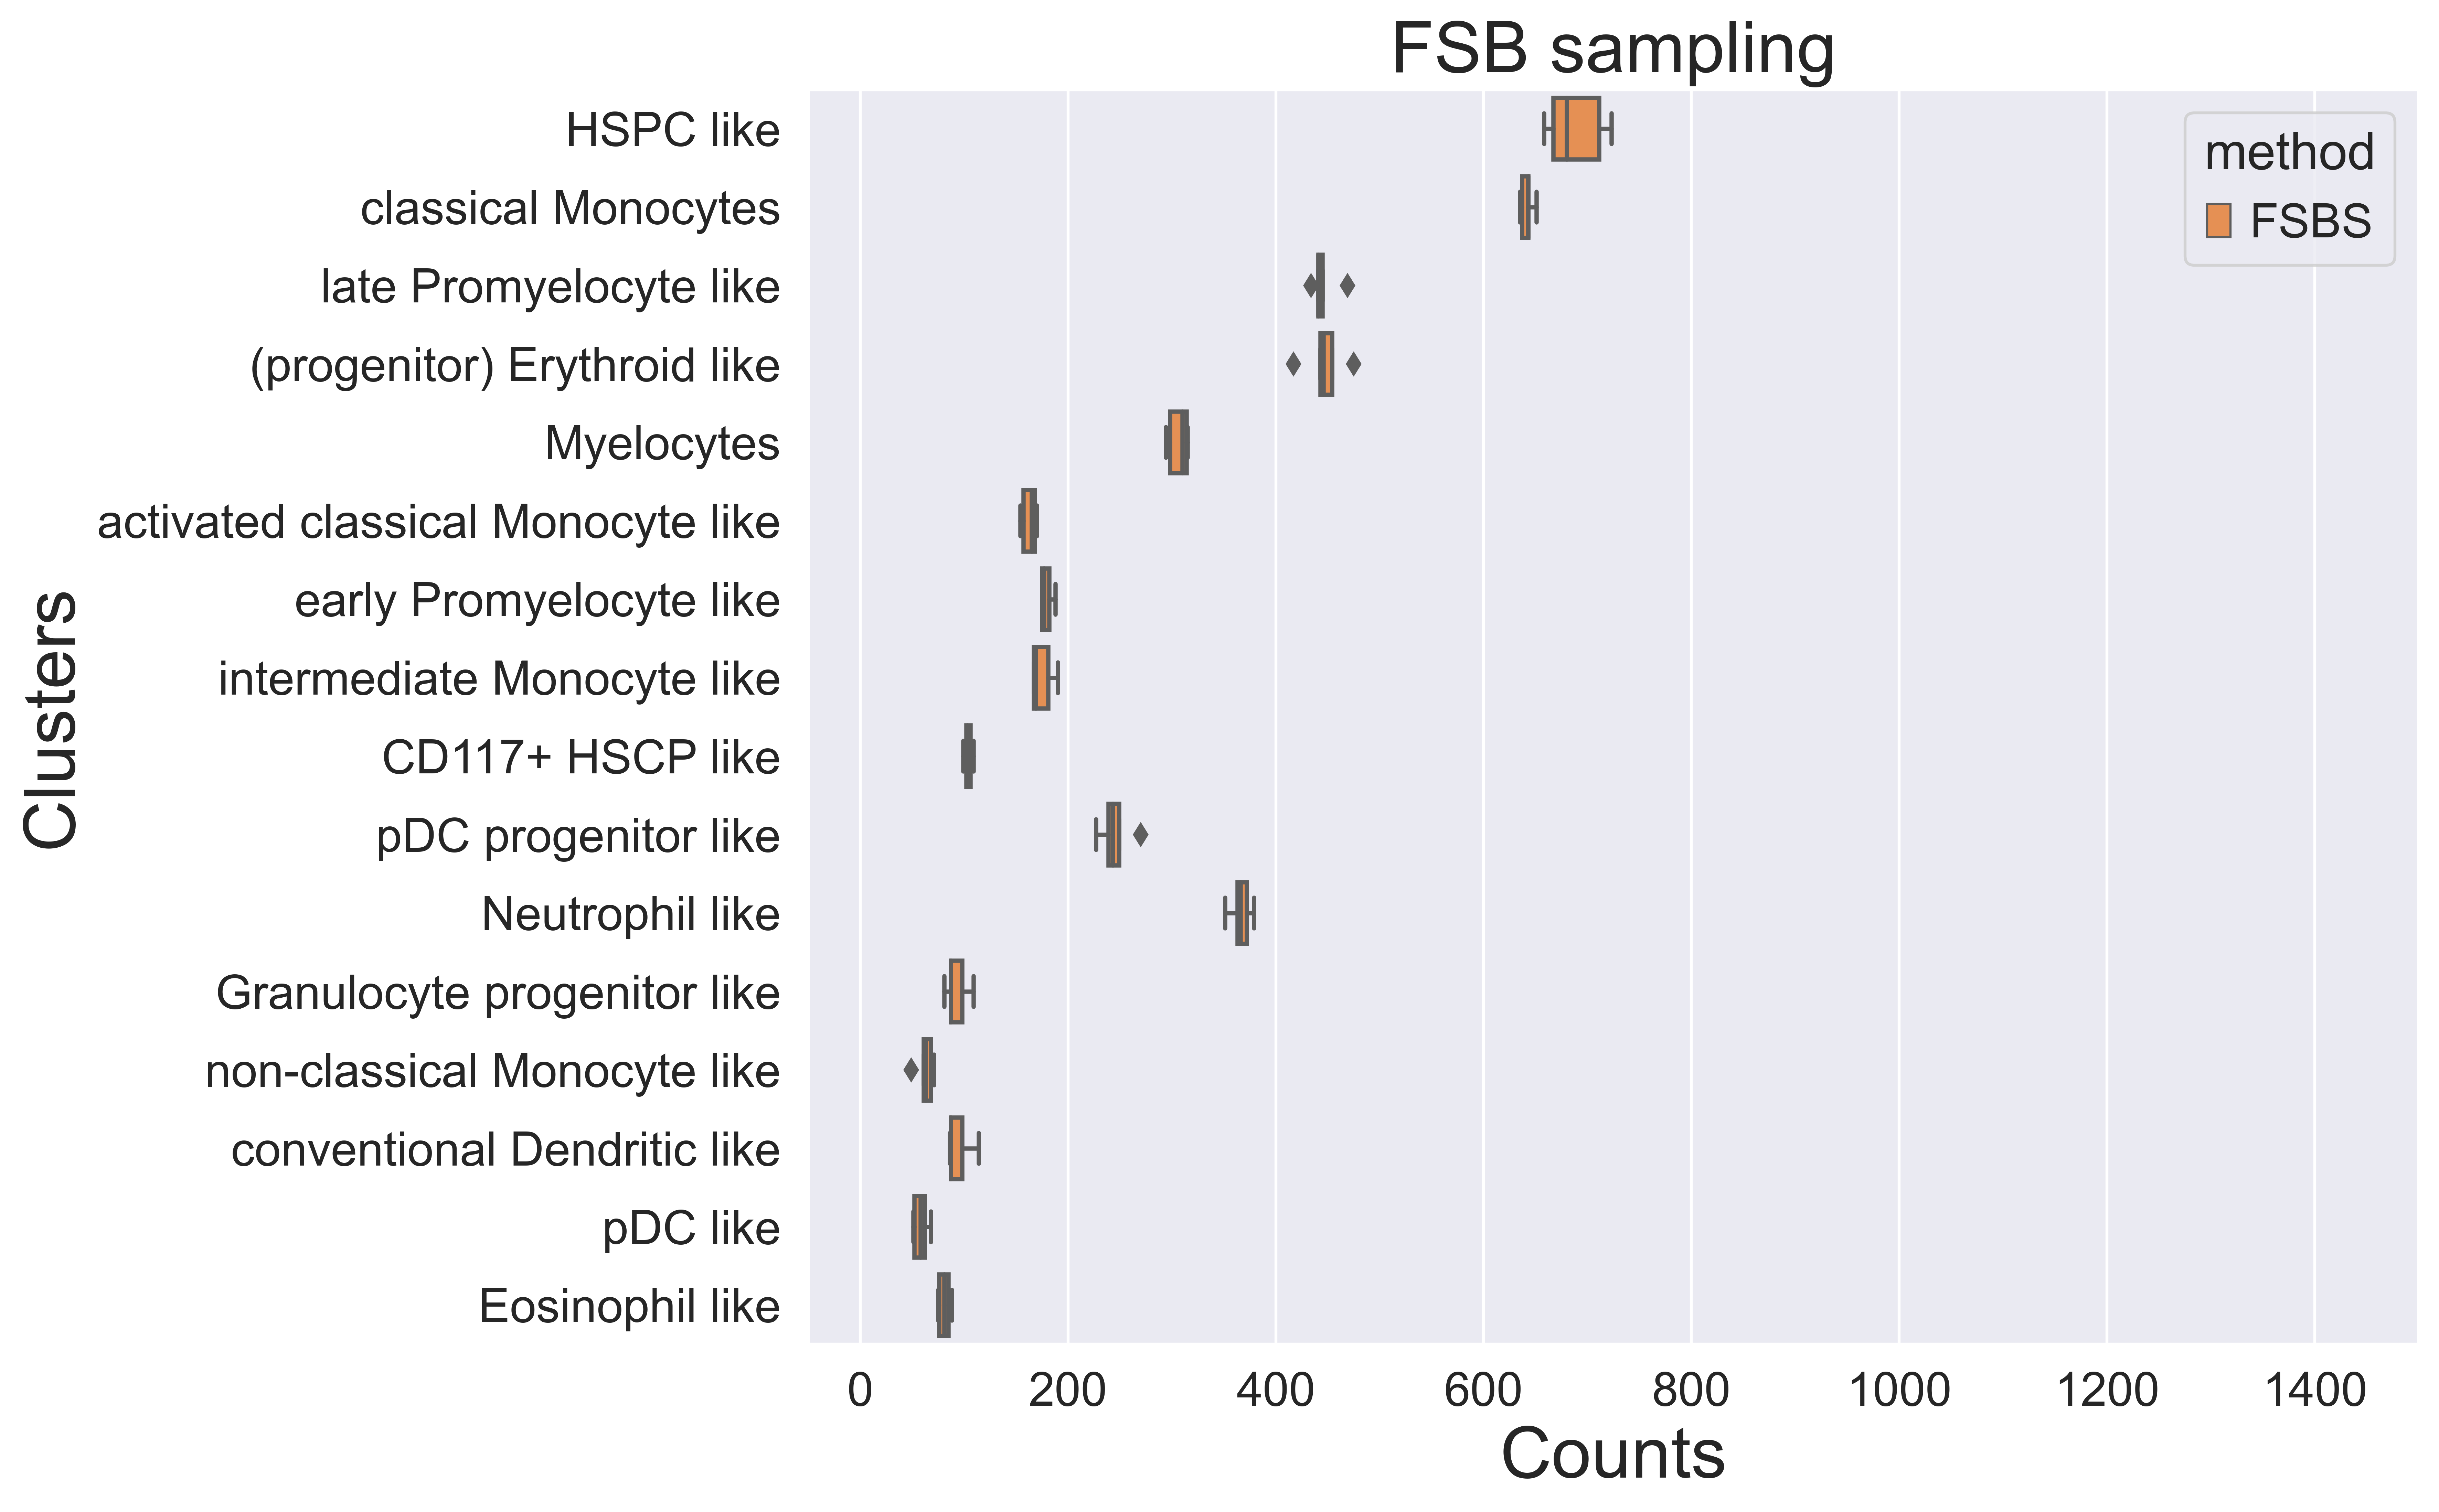

In [32]:
plt.figure(figsize=(10, 8))
g = sns.boxplot(y=label_key, x="count", hue='method',data=df_fsbs,
                orient='h', order= cell_type_order, palette='Oranges')
plt.xlim(-50, 1500)
# plt.xticks(rotation=90)
plt.ylabel("Clusters", size = 25)
plt.xlabel("Counts", size = 25)
plt.title("FSB sampling",  size= 25)
plt.savefig("Fixed_size_bin_sampling_new.png", dpi=200, bbox_inches='tight', pad_inches = 0.5)

In [33]:
adata.obs[label_key].value_counts()

HSPC like                            228951
classical Monocytes                  208954
late Promyelocyte like               166192
(progenitor) Erythroid like          117194
Myelocytes                            51541
activated classical Monocyte like     50252
early Promyelocyte like               32936
intermediate Monocyte like            30002
CD117+ HSCP like                      27794
pDC progenitor like                   24422
Neutrophil like                       14198
Granulocyte progenitor like           13140
non-classical Monocyte like           12448
conventional Dendritic like           11539
pDC like                               6117
Eosinophil like                        4320
Name: Population, dtype: int64

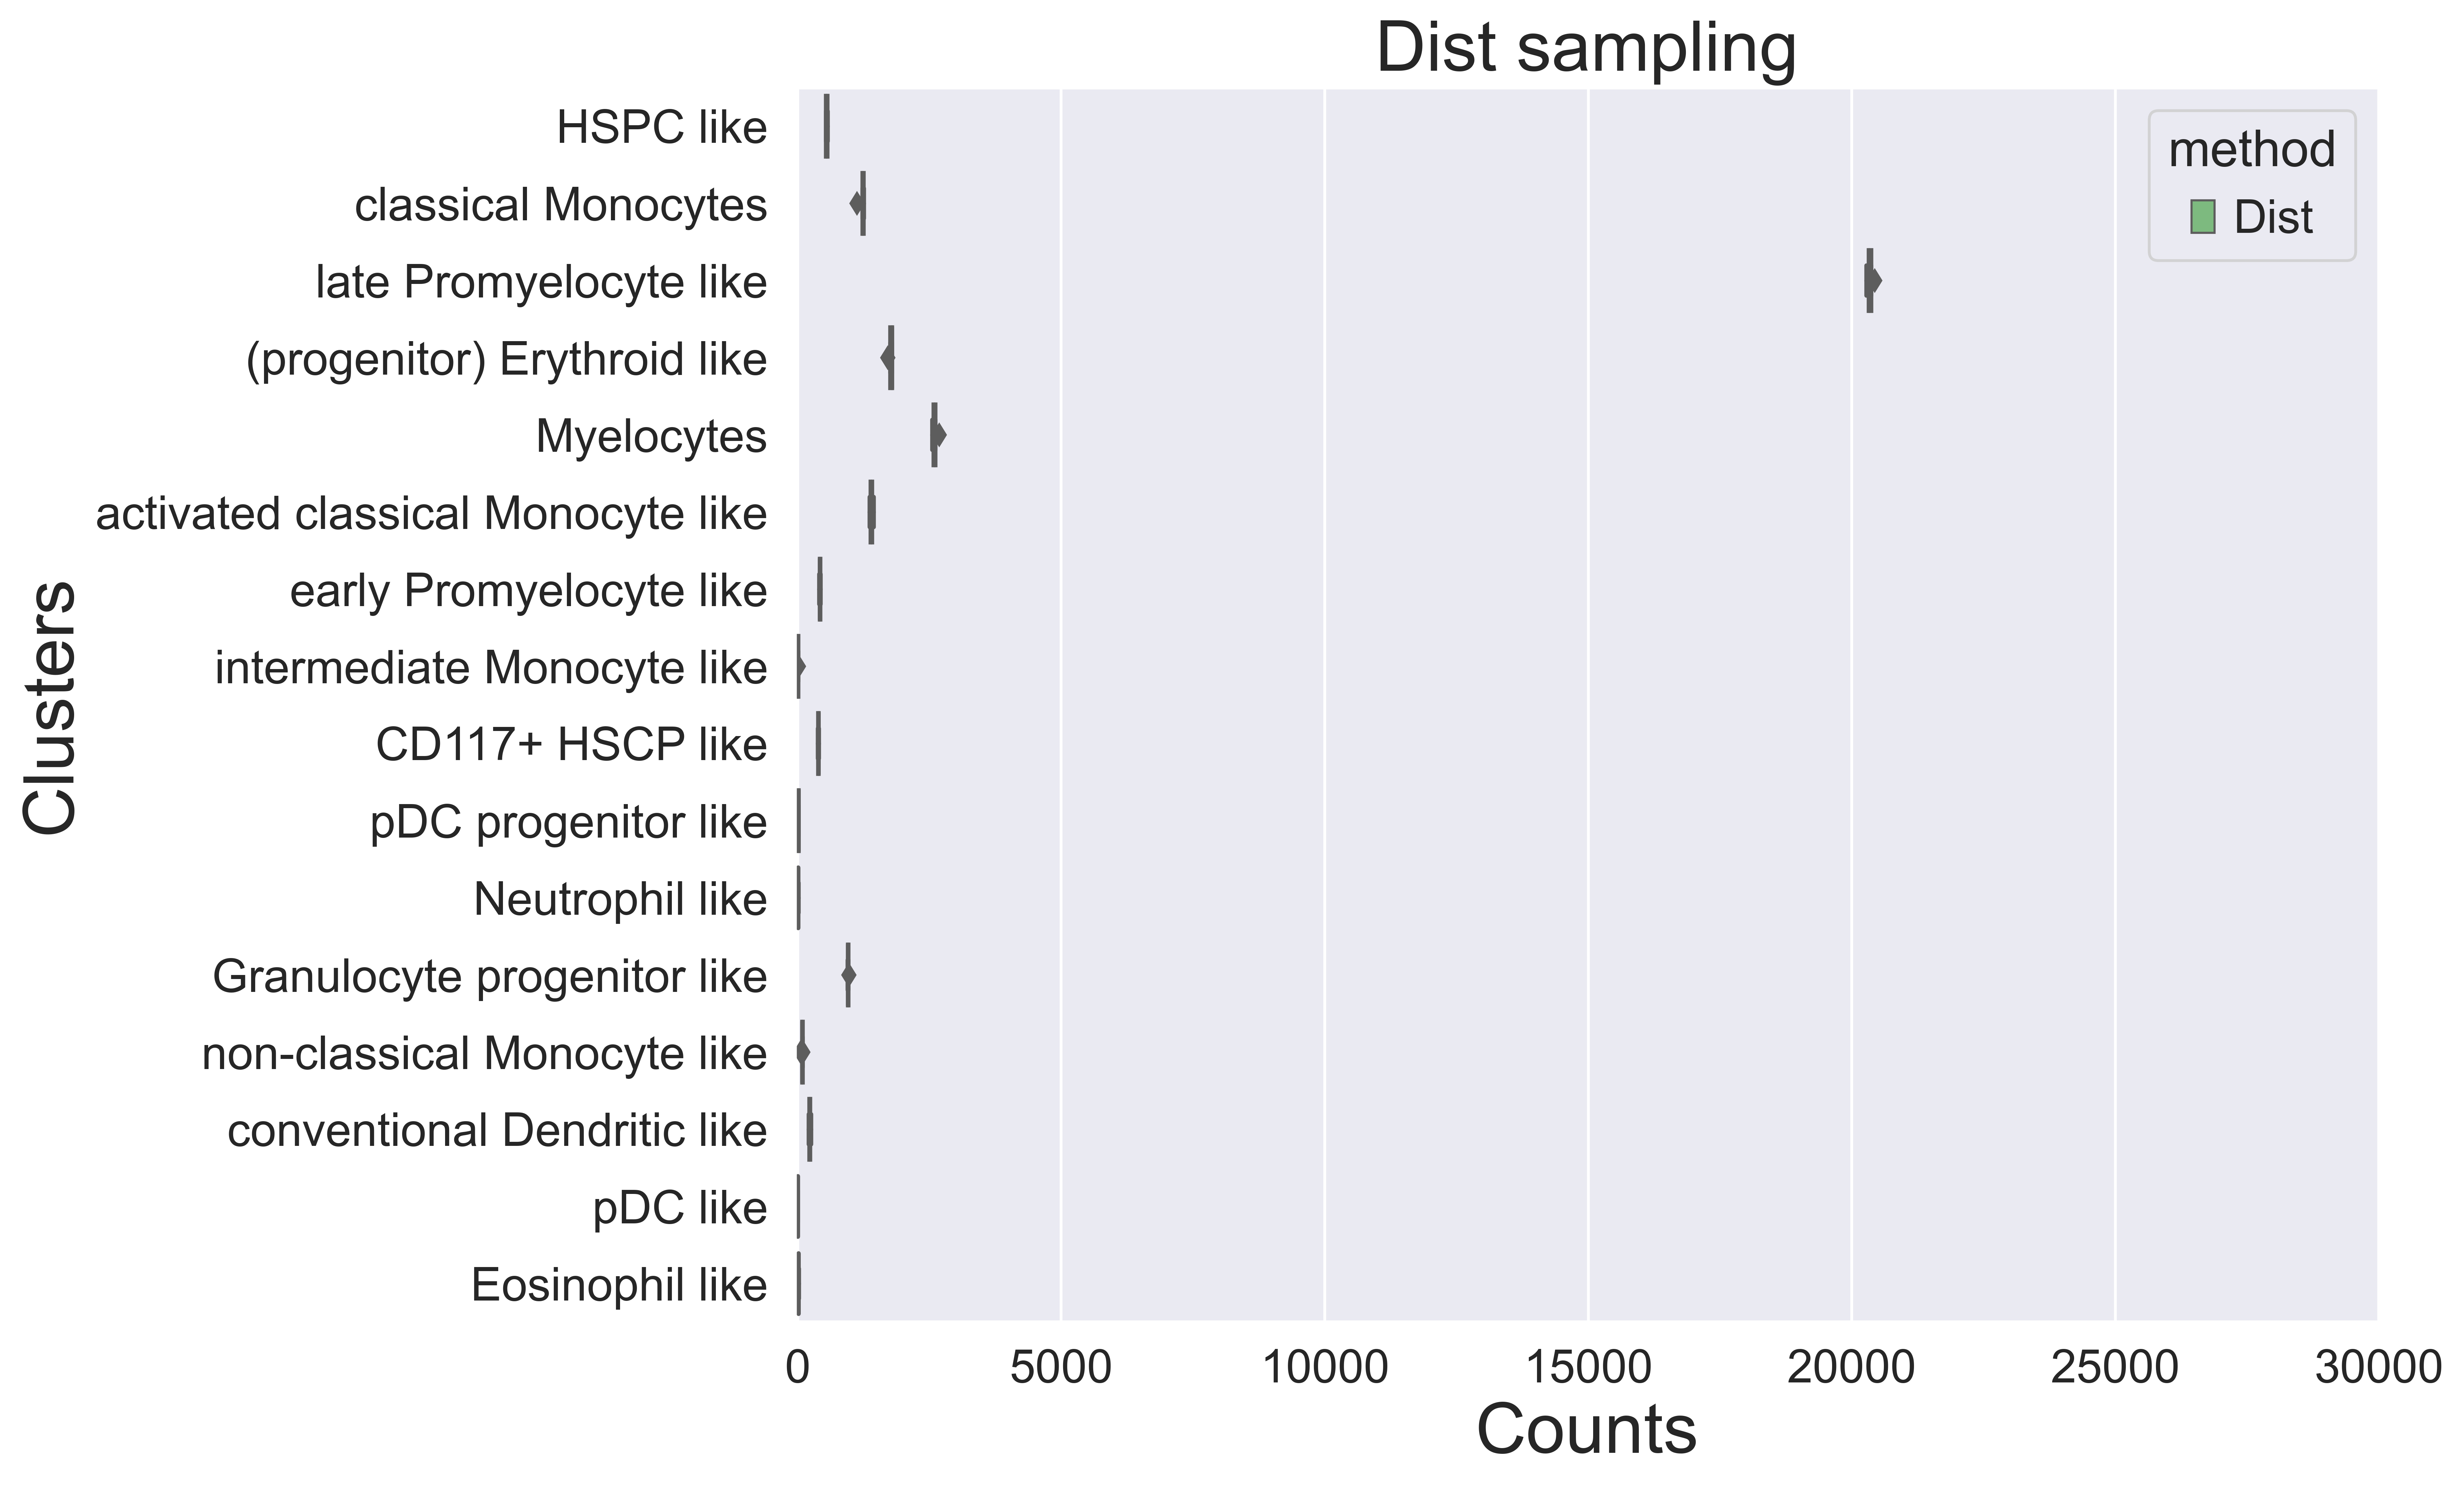

In [34]:
plt.figure(figsize=(10, 8))
g = sns.boxplot(y=label_key, x="count", hue='method',data=df_dist,
                orient='h', order= cell_type_order, palette="Greens")
plt.xlim(-50, 30000)
# plt.xticks(rotation=90)
plt.ylabel("Clusters", size = 25)
plt.xlabel("Counts", size = 25)
plt.title("Dist sampling",  size= 25)
plt.savefig("Dist_sampling_new.png", dpi=200, bbox_inches='tight', pad_inches = 0.5)

### Check the MNN

In [35]:
from FACS_Sampling.methods.analysis import get_knn_classification_report

In [61]:
print(get_knn_classification_report(random_samples, ref_adata, label_key)[1])

                                   precision    recall  f1-score   support

      (progenitor) Erythroid like       0.92      0.93      0.93    113624
                 CD117+ HSCP like       0.80      0.63      0.71     26956
                  Eosinophil like       0.80      0.85      0.83      4175
      Granulocyte progenitor like       0.89      0.69      0.78     12695
                        HSPC like       0.93      0.98      0.95    221898
                       Myelocytes       0.87      0.80      0.84     49983
                  Neutrophil like       0.97      0.94      0.95     13772
activated classical Monocyte like       0.91      0.91      0.91     48734
              classical Monocytes       0.94      0.98      0.96    202653
      conventional Dendritic like       0.88      0.72      0.79     11200
          early Promyelocyte like       0.87      0.81      0.84     31916
       intermediate Monocyte like       0.89      0.84      0.86     29074
           late Promyelo

In [62]:
print(get_knn_classification_report(fsbs_samples, ref_adata, label_key)[1])

                                   precision    recall  f1-score   support

      (progenitor) Erythroid like       0.92      0.93      0.92    114165
                 CD117+ HSCP like       0.77      0.63      0.70     27029
                  Eosinophil like       0.79      0.85      0.82      3848
      Granulocyte progenitor like       0.89      0.69      0.78     12533
                        HSPC like       0.94      0.97      0.95    223709
                       Myelocytes       0.89      0.77      0.83     49624
                  Neutrophil like       0.95      0.95      0.95     11723
activated classical Monocyte like       0.91      0.90      0.90     48967
              classical Monocytes       0.94      0.98      0.96    203730
      conventional Dendritic like       0.87      0.75      0.80     10864
          early Promyelocyte like       0.86      0.81      0.84     31631
       intermediate Monocyte like       0.88      0.87      0.88     28732
           late Promyelo

### XGBoost

In [80]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
# read data
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [84]:

def get_xgboos_classification_report(index_subset, ref_adata, label_key='labels'):
    small_adata = ref_adata[index_subset]
    bad_inds = small_adata.obs.index
    bad_df = ref_adata.obs.index.isin(bad_inds)

    X_train = small_adata.X
    y_train = small_adata.obs[label_key]
    X_test = ref_adata[~bad_df].X
    y_test = ref_adata[~bad_df].obs[label_key]

#     clf = neighbors.KNeighborsClassifier(n_neighbors=5)
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)

#     cr = classification_report(y_test, y_pred, output_dict=True)
#     crc = classification_report(y_test, y_pred)
#     df_cr = pd.DataFrame(cr)
    
    
    encoder = LabelEncoder()
    encoded_y_train = encoder.fit_transform(y_train)
    encoded_y_test = encoder.fit_transform(y_test)

    xg_train = xgb.DMatrix(X_train, label=encoded_y_train)
    xg_test = xgb.DMatrix(X_test, label=encoded_y_test)
    # setup parameters for xgboost
    param = {}
    # use softmax multi-class classification
    param['objective'] = 'multi:softmax'
    # scale weight of positive examples
    param['eta'] = 0.5
    param['max_depth'] = 8
    param['nthread'] = 4
    param['num_class'] = 16

    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    num_round = 5
    bst = xgb.train(param, xg_train, num_round, watchlist)
    # get prediction
    pred = bst.predict(xg_test).astype(int)
    error_rate = np.sum(pred != encoded_y_test) / encoded_y_test.shape[0]
    print('Test error using softmax = {}'.format(error_rate))
    
#     print(pred[1:5])
#     print(encoded_y_test[1:5])
    decoded_y_pred = encoder.inverse_transform(pred)
    cr = classification_report(y_test, decoded_y_pred, output_dict=True)
    crc = classification_report(y_test, decoded_y_pred)
    df_cr = pd.DataFrame(cr)
    print(crc)

In [85]:
get_xgboos_classification_report(random_samples, ref_adata, label_key)

/Users/ekarimi/opt/anaconda3/envs/FACS_Sampling/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-mlogloss:0.56138	test-mlogloss:0.70097
[1]	train-mlogloss:0.39415	test-mlogloss:0.55579
[2]	train-mlogloss:0.29079	test-mlogloss:0.46565
[3]	train-mlogloss:0.22023	test-mlogloss:0.40641
[4]	train-mlogloss:0.17128	test-mlogloss:0.36679
Test error using softmax = 0.10593125070904796
                                   precision    recall  f1-score   support

      (progenitor) Erythroid like       0.92      0.89      0.90    113624
                 CD117+ HSCP like       0.71      0.57      0.64     26956
                  Eosinophil like       0.76      0.70      0.73      4175
      Granulocyte progenitor like       0.75      0.68      0.71     12695
                        HSPC like       0.93      0.96      0.94    221898
                       Myelocytes       0.80      0.77      0.79     49983
                  Neutrophil like       0.95      0.90      0.92     13772
activated classical Monocyte like       0.88      0.87      0.88     48734
              classical Monocyte

In [86]:
get_xgboos_classification_report(fsbs_samples, ref_adata, label_key)

/Users/ekarimi/opt/anaconda3/envs/FACS_Sampling/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-mlogloss:0.61744	test-mlogloss:0.71586
[1]	train-mlogloss:0.43773	test-mlogloss:0.56455
[2]	train-mlogloss:0.32634	test-mlogloss:0.47326
[3]	train-mlogloss:0.24832	test-mlogloss:0.41002
[4]	train-mlogloss:0.19221	test-mlogloss:0.36708
Test error using softmax = 0.10583842988418024
                                   precision    recall  f1-score   support

      (progenitor) Erythroid like       0.92      0.89      0.90    114165
                 CD117+ HSCP like       0.72      0.52      0.61     27029
                  Eosinophil like       0.81      0.75      0.78      3848
      Granulocyte progenitor like       0.76      0.70      0.73     12533
                        HSPC like       0.93      0.96      0.94    223709
                       Myelocytes       0.82      0.75      0.78     49624
                  Neutrophil like       0.93      0.94      0.93     11723
activated classical Monocyte like       0.90      0.87      0.88     48967
              classical Monocyte

In [53]:
xg_train = xgb.DMatrix(X_train, label=y_train)
xg_test = xgb.DMatrix(X_test, label=y_test)
# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 6
param['nthread'] = 4
param['num_class'] = 16

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 5
bst = xgb.train(param, xg_train, num_round, watchlist)
# get prediction
pred = bst.predict(xg_test)
error_rate = np.sum(pred != test_Y) / test_Y.shape[0]
print('Test error using softmax = {}'.format(error_rate))

NameError: name 'X_train' is not defined